In [33]:
import gym
import torch
import numpy as np
import random
from collections import deque

# For visualization
import matplotlib.pyplot as plt
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display 
import glob

This notebook delves into the deployment of a Deep Q-Learning (DQN) agent designed to navigate the Lunar Lander environment in Gym. We will explore three adaptations of the DQN algorithm, namely:
1. DQN 
2. Dueling DQN
3. Double Dueling DQN



## General Information
The provided details are sourced from the Gym documentation, accessible at https://www.gymlibrary.dev/environments/box2d/lunar_lander/.

## Action Space
The action space is discrete with four options: do nothing, activate the left orientation engine, activate the main engine, and activate the right orientation engine.

| Action	| Outcome |
|-----------|---------|
| 0	        | Do nothing | 
| 1       	| Activate the left orientation engine |
| 2	        | Activate the main engine |
| 3	        | Activate the right orientation engine |



## Observation Space
The state is an 8-dimensional vector, encompassing the lander's coordinates, linear velocities, angle, angular velocity, and indicators of each leg's contact with the ground.


| Observation  | Value                                   |
|--------------|-----------------------------------------|
| 0            | x coordinate (float)                  |
| 1            | y coordinate (float)                  |
| 2            | x linear velocity (float)             |
| 3            | y linear velocity (float)             |
| 4            | Angle in radians from -π to +π (float)  |
| 5            | Angular velocity (float)                |
| 6            | Left leg contact (bool)                 |
| 7            | Right leg contact (bool)                |

## Rewards
Moving from the top of the screen to the landing pad and coming to rest yields approximately 100-140 points. Departing from the landing pad results in a loss of reward, while a crash incurs an additional -100 points. Coming to a standstill earns an extra +100 points, and each leg in contact with the ground adds +10 points. Firing the main engine deducts -0.3 points per frame, and firing the side engine deducts -0.03 points per frame. The goal for solving is to reach 200 points.

## Starting State
The lander commences at the top center of the viewport, subject to a random initial force applied to its center of mass.

## Episode Termination
An episode concludes under the following conditions:
1. The lander crashes (body contact with the moon)
2. The lander exits the viewport (x coordinate exceeds 1)
3. The lander is not awake, where an inactive body doesn't move or collide with other bodies (per Box2D documentation)

In [28]:
env = gym.make('LunarLander-v2')
env.reset(seed=42)

# Play one complete episode with random actions
while True:
    action = env.action_space.sample() 
    _, _, terminated, truncated, _ = env.step(action)
    if terminated or truncated:
        break
    
env.close()

The safe agent is designed to ascend vertically when the lander approaches dangerously close to the ground. It has a method that serves as the decision-making mechanism, instructing the agent to ascend if the altitude is below a predefined minimum height and then orchestrates the execution of a complete episode for the specified agent, environment, and seed.

In [29]:
class SafeAgent:
   
    def act(self, state):

        MIN_HEIGHT = 1

        if state[1] < MIN_HEIGHT:
            return 2
        else:
            return 0


def play_episode(env, agent, seed=42):
   
    score = 0
    state, _ = env.reset(seed=seed)
    
    while True:
        env.render()

        action = agent.act(state)
        state, reward, terminated, truncated, _ = env.step(action) 
        done = terminated or truncated

        score += reward

        # End the episode if done
        if done:
            break 

    env.close()


env = gym.make('LunarLander-v2')
agent = SafeAgent()

play_episode(env, agent)

The stable agent describes an agent tasked with maintaining stable flight of the lander through a predefined set of rigid rules and outlines the decision-making process, directing the agent to adhere to the established rules for stable flight.

In [21]:
class StableAgent:
    
    def act(self, state):
        
        # thresholds
        UPPER_MIN_Y = 1.5
        LOWER_MIN_Y = 1
        MIN_X = -0.4
        MAX_X = 0.4
        MIN_ANGLE = -3.14/50
        MAX_ANGLE = 3.14/50

        # angle, x and y coordinates
        x = state[0]
        y = state[1]
        angle = state[4]

        # Avoiding magic numbers for readability
        MAIN_ENGINE = 2
        LEFT_ENGINE = 1
        RIGHT_ENGINE = 3
        DO_NOTHING = 0

        # when low - use main engine
        if y < LOWER_MIN_Y:
            return MAIN_ENGINE

        # to keep angle within a small range
        elif angle > MAX_ANGLE:
            return RIGHT_ENGINE
        elif angle < MIN_ANGLE:
            return LEFT_ENGINE
        
        # Don't go too far left or right
        elif x > MAX_X:
            return LEFT_ENGINE
        elif x < MIN_X:
            return RIGHT_ENGINE
        
        # If stable - main engine to maintain height
        elif y < UPPER_MIN_Y:
            return MAIN_ENGINE
        
        # Else do nothing
        else:
            return DO_NOTHING


env = gym.make('LunarLander-v2')
agent = StableAgent()

play_episode(env, agent)

This class is dedicated to defining a deep Q-network (DQN). The primary function of the DQN is to estimate Q-values, serving as representations of the expected return for each action within a given state.

The DQN can be initialized with parameters such as the size of the state space (state_size), the size of the action space (action_size), and the size of the hidden layers in the network (hidden_size).

The __init__ method initializes a network with a specific architecture, including an input layer of dimensions (state_size, hidden_size), a hidden layer of dimensions (hidden_size, hidden_size), and an output layer of dimensions (hidden_size, action_size).

The forward method defines the forward pass of the DQN, activated when the network is called to estimate Q-values. It takes a state as input, represented as a PyTorch tensor, and returns the estimated Q-values for each action in the input state as a PyTorch tensor.


In [5]:


class DQN(torch.nn.Module):

    def __init__(self, state_size=8, action_size=4, hidden_size=64):

        super(DQN, self).__init__()
        self.layer1 = torch.nn.Linear(state_size, hidden_size)
        self.layer2 = torch.nn.Linear(hidden_size, hidden_size)
        self.layer3 = torch.nn.Linear(hidden_size, action_size)

    def forward(self, state):

        x = torch.relu(self.layer1(state))
        x = torch.relu(self.layer2(x))
        return self.layer3(x)

This class serves as a representation of a replay buffer, a fundamental data structure frequently employed in reinforcement learning algorithms. The buffer is designed to store past experiences in the environment, enabling the agent to later sample and learn from them. This mechanism helps alleviate the correlation among sequential observations, contributing to the stabilization of the learning process.

The buffer can be initialized with a specified maximum number of experiences using the buffer_size parameter.

The add_experience method allows for the addition of a new experience to the buffer. Each experience is encapsulated within a tuple comprising the state before taking the action, the action itself, the ensuing reward, the resulting next state, and a flag indicating whether the episode has concluded.

The sample method facilitates the random sampling of a batch of experiences from the buffer, with the batch size limited to being smaller or equal to the current number of experiences in the buffer. It returns a tuple containing arrays of states, actions, rewards, next states, and flags denoting episode completion.

Lastly, the get_size method provides the current number of experiences present in the buffer, returning an integer value representing the count.

In [6]:
class ReplayBuffer:

    def __init__(self, buffer_size=10000):
        self.buffer = deque(maxlen=buffer_size)

    def push(self, state, action, reward, next_state, done):

        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):

        states, actions, rewards, next_states, dones = zip(*random.sample(self.buffer, batch_size))
        return np.stack(states), actions, rewards, np.stack(next_states), dones

    def __len__(self):

        return len(self.buffer)

This class defines a Deep Q-Learning agent employing a Deep Q-Network (DQN) and a replay memory to interact with its environment. It takes various parameters such as the size of the state space (state_size), the size of the action space (action_size), the size of hidden layers in the network (hidden_size), learning rate for the optimizer (learning_rate), discount factor for future rewards (gamma), maximum size of the replay memory (buffer_size), and batch size for learning from the replay memory (batch_size).

The step method performs a step in the environment, storing the experience in the replay memory, and potentially updating the Q-network. It takes parameters such as the current state of the environment (state), the action taken by the agent (action), the reward received after taking the action (reward), the state of the environment after taking the action (next_state), and a flag indicating whether the episode has ended after taking the action (done).

The act method chooses an action based on the current state and the epsilon-greedy policy. It takes parameters such as the current state of the environment (state) and epsilon for the epsilon-greedy policy (eps). With a probability of eps, a random action is chosen, and it returns the chosen action as an integer.

In [7]:
class DQNAgent:

    def __init__(self, state_size=8, action_size=4, hidden_size=64, 
                 learning_rate=1e-3, gamma=0.99, buffer_size=10000, batch_size=64):
        # Select device to train on (if CUDA available, use it, otherwise use CPU)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # Discount factor for future rewards
        self.gamma = gamma

        # Batch size for sampling from the replay memory
        self.batch_size = batch_size

        # Number of possible actions
        self.action_size = action_size

        # Initialize the Q-Network and Target Network with the given state size, action size and hidden layer size
        # Move the networks to the selected device
        self.q_network = DQN(state_size, action_size, hidden_size).to(self.device)
        self.target_network = DQN(state_size, action_size, hidden_size).to(self.device)
        
        # Set weights of target network to be the same as those of the q network
        self.target_network.load_state_dict(self.q_network.state_dict())
        
        # Set target network to evaluation mode
        self.target_network.eval()

        # Initialize the optimizer for updating the Q-Network's parameters
        self.optimizer = torch.optim.Adam(self.q_network.parameters(), lr=learning_rate)
        
        # Initialize the replay memory
        self.memory = ReplayBuffer(buffer_size)

    def step(self, state, action, reward, next_state, done):

        # Store the experience in memory
        self.memory.push(state, action, reward, next_state, done)
        
        # If there are enough experiences in memory, perform a learning step
        if len(self.memory) > self.batch_size:
            self.update_model()

    def act(self, state, eps=0.):

        # If a randomly chosen value is greater than eps
        if random.random() > eps:  
            # Convert state to a PyTorch tensor and set network to evaluation mode
            state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)  
            self.q_network.eval()  

            # With no gradient updates, get the action values from the DQN
            with torch.no_grad():
                action_values = self.q_network(state)

            # Revert to training mode and return action
            self.q_network.train() 
            return np.argmax(action_values.cpu().data.numpy())
        else:
            # Return a random action for random value > eps
            return random.choice(np.arange(self.action_size))  
        
    def update_model(self):
        # Sample a batch of experiences from memory
        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)

        # Convert numpy arrays to PyTorch tensors
        states = torch.from_numpy(states).float().to(self.device)
        actions = torch.from_numpy(np.array(actions)).long().to(self.device)
        rewards = torch.from_numpy(np.array(rewards)).float().to(self.device)
        next_states = torch.from_numpy(next_states).float().to(self.device)
        dones = torch.from_numpy(np.array(dones).astype(np.uint8)).float().to(self.device)

        # Get Q-values for the actions that were actually taken
        q_values = self.q_network(states).gather(1, actions.unsqueeze(-1)).squeeze(-1)
        
        # Get maximum Q-value for the next states from target network
        next_q_values = self.target_network(next_states).max(1)[0].detach()
        
        # Compute the expected Q-values
        expected_q_values = rewards + self.gamma * next_q_values * (1 - dones)

        # Compute the loss between the current and expected Q values
        loss = torch.nn.MSELoss()(q_values, expected_q_values)
        
        # Zero all gradients
        self.optimizer.zero_grad()
        
        # Backpropagate the loss
        loss.backward()
        
        # Step the optimizer
        self.optimizer.step()

    def update_target_network(self):

        self.target_network.load_state_dict(self.q_network.state_dict())

This function trains a DQN, taking the agent to be trained (agent) and the training environment (env) as parameters. Additionally, it accepts optional parameters such as the number of episodes (n_episodes), starting epsilon for epsilon-greedy action selection (eps_start), the minimum value epsilon can reach (eps_end), the decay rate for epsilon after each episode (eps_decay), and the frequency with which the target network should be updated (target_update). The function returns a list of floats representing the total reward obtained in each episode.



    

In [8]:
def train(agent, env, n_episodes=2000, eps_start=1.0, eps_end=0.01, eps_decay=0.995, target_update=10):


    # Initialize the scores list and scores window
    scores = []
    scores_window = deque(maxlen=100)
    eps = eps_start

    # Loop over episodes
    for i_episode in range(1, n_episodes + 1):
        
        # Reset environment and score at the start of each episode
        state, _ = env.reset()
        score = 0 

        # Loop over steps
        while True:
            
            # Select an action using current agent policy
            action = agent.act(state, eps)
            next_state, reward, terminated, truncated, _ = env.step(action) 
            done = terminated or truncated
            
            # Update the agent, state and score
            agent.step(state, action, reward, next_state, done)
            state = next_state 
            score += reward

            # End the episode if done
            if done:
                break 
        
        # At the end of episode append and save scores
        scores_window.append(score)
        scores.append(score) 

        # Decrease epsilon
        eps = max(eps_end, eps_decay * eps)

        print(f"\rEpisode {i_episode}\tAverage Score: {np.mean(scores_window):.2f}", end="")

        # Update target network every target_update episodes
        if i_episode % target_update == 0:
            agent.update_target_network()
            
        # Print average score every 100 episodes
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        
        # for a mean score of 200 or greater stop training.
        if i_episode % 100 == 0 and np.mean(scores_window) >= 200:
            break
            

    return scores


# environment
env = gym.make('LunarLander-v2')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

# Initilize a DQN agent
agent = DQNAgent(state_size, action_size)

# Training
scores = train(agent, env)

Episode 100	Average Score: -125.99
Episode 200	Average Score: -82.853
Episode 300	Average Score: -73.26
Episode 400	Average Score: 25.550
Episode 500	Average Score: 102.14
Episode 600	Average Score: 153.23
Episode 700	Average Score: 72.983
Episode 800	Average Score: 110.74
Episode 900	Average Score: 95.678
Episode 1000	Average Score: 143.62
Episode 1100	Average Score: 200.72


In [9]:
env = gym.make('LunarLander-v2')

def play_DQN_episode(env, agent):
    score = 0
    state, _ = env.reset(seed=42)
    
    while True:
        # eps=0 for predictions
        action = agent.act(state, 0)
        state, reward, terminated, truncated, _ = env.step(action) 
        done = terminated or truncated

        score += reward

        # End the episode if done
        if done:
            break 

    return score
 
score = play_DQN_episode(env, agent)
print("Score obtained:", score)

Score obtained: 222.4372733199766


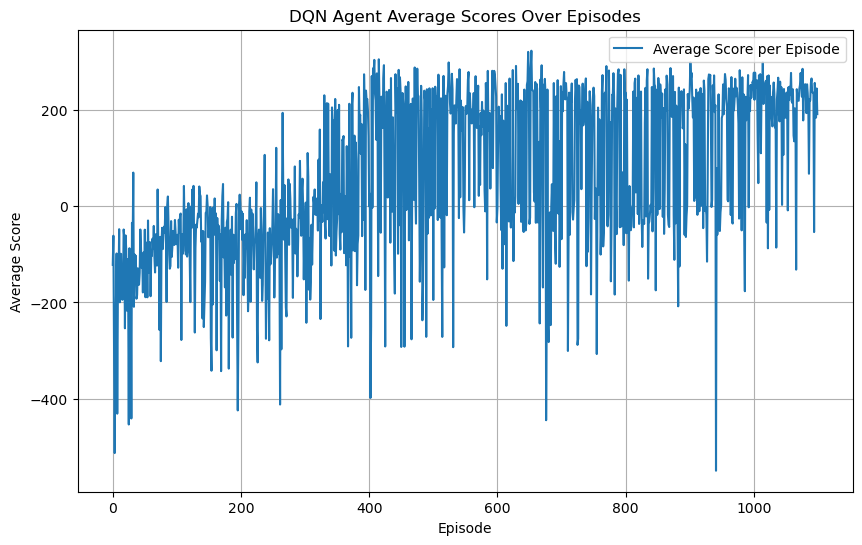

In [10]:
# Function to plot average scores
def plot_scores(scores, title):
    plt.figure(figsize=(10, 6))
    plt.plot(scores, label='Average Score per Episode')
    plt.title(title)
    plt.xlabel('Episode')
    plt.ylabel('Average Score')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plotting
plot_scores(scores, 'DQN Agent Average Scores Over Episodes')


In [16]:
class DuelingDQN(torch.nn.Module):

    def __init__(self, state_size=8, action_size=4, hidden_size=64):
 
        super(DuelingDQN, self).__init__()

        # Common layers
        self.layer1 = torch.nn.Linear(state_size, hidden_size)
        self.layer2 = torch.nn.Linear(hidden_size, hidden_size)

        # Advantage layer
        self.advantage = torch.nn.Linear(hidden_size, action_size)

        # Value layer
        self.value = torch.nn.Linear(hidden_size, 1)

    def forward(self, state):

        # Common part of the network
        x = torch.relu(self.layer1(state))
        x = torch.relu(self.layer2(x))

        # Streams split
        advantage = self.advantage(x)
        value = self.value(x)

        # Recombine advantage and value of q
        return value + (advantage - advantage.max(dim=1, keepdim=True)[0])
    

class DuelingDQNAgent:

    def __init__(self, state_size=8, action_size=4, hidden_size=64, 
                 learning_rate=1e-3, gamma=0.99, buffer_size=10000, batch_size=64):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.gamma = gamma
        self.batch_size = batch_size
        self.action_size = action_size

        # Using dueling DQN networks
        self.q_network = DuelingDQN(state_size, action_size, hidden_size).to(self.device)
        self.target_network = DuelingDQN(state_size, action_size, hidden_size).to(self.device)

        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()
        self.optimizer = torch.optim.Adam(self.q_network.parameters(), lr=learning_rate)
        self.memory = ReplayBuffer(buffer_size)

    def step(self, state, action, reward, next_state, done):
        self.memory.push(state, action, reward, next_state, done)
        if len(self.memory) > self.batch_size:
            self.update_model()

    def act(self, state, eps=0.):
        if random.random() > eps:  
            state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)  
            self.q_network.eval()
            with torch.no_grad():
                action_values = self.q_network(state)
            self.q_network.train() 
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))  
        
    def update_model(self):
        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)
        states = torch.from_numpy(states).float().to(self.device)
        actions = torch.from_numpy(np.array(actions)).long().to(self.device)
        rewards = torch.from_numpy(np.array(rewards)).float().to(self.device)
        next_states = torch.from_numpy(next_states).float().to(self.device)
        dones = torch.from_numpy(np.array(dones).astype(np.uint8)).float().to(self.device)
        q_values = self.q_network(states).gather(1, actions.unsqueeze(-1)).squeeze(-1)
        next_q_values = self.target_network(next_states).max(1)[0].detach()
        expected_q_values = rewards + self.gamma * next_q_values * (1 - dones)
        loss = torch.nn.MSELoss()(q_values, expected_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

# environment
env = gym.make('LunarLander-v2')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

# Initilize a DuelingDQN agent
agent = DuelingDQNAgent(state_size, action_size)

# Training
scores = train(agent, env)

# demonstration episode
score = play_DQN_episode(env, agent)
print("Score obtained:", score)

Episode 100	Average Score: -118.67
Episode 200	Average Score: -58.081
Episode 300	Average Score: -69.35
Episode 400	Average Score: -31.97
Episode 500	Average Score: 25.696
Episode 600	Average Score: 69.14
Episode 700	Average Score: 169.81
Episode 800	Average Score: 193.77
Episode 900	Average Score: 249.16
Score obtained: 229.07798975369613


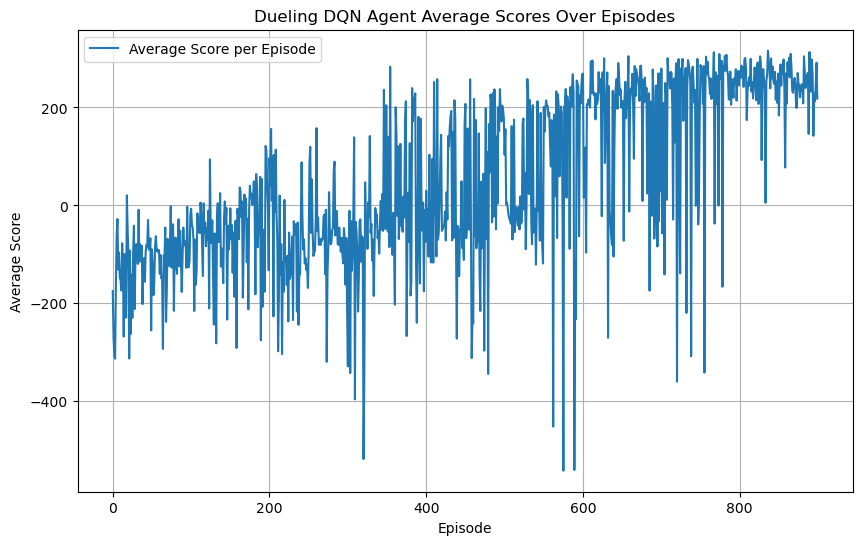

In [17]:
plot_scores(scores, 'Dueling DQN Agent Average Scores Over Episodes')

In [13]:
class DoubleDuelDQNAgent:
    def __init__(self, state_size=8, action_size=4, hidden_size=64, 
                 learning_rate=1e-3, gamma=0.99, buffer_size=10000, batch_size=64):

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.gamma = gamma
        self.batch_size = batch_size
        self.action_size = action_size
        self.q_network = DuelingDQN(state_size, action_size, hidden_size).to(self.device)
        self.target_network = DuelingDQN(state_size, action_size, hidden_size).to(self.device)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()
        self.optimizer = torch.optim.Adam(self.q_network.parameters(), lr=learning_rate)
        self.memory = ReplayBuffer(buffer_size)

    def step(self, state, action, reward, next_state, done):
        self.memory.push(state, action, reward, next_state, done)
        if len(self.memory) > self.batch_size:
            self.update_model()

    def act(self, state, eps=0.):
        if random.random() > eps:  
            state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)  
            self.q_network.eval()  
            with torch.no_grad():
                action_values = self.q_network(state)

            self.q_network.train() 
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))  
        
    def update_model(self):
        # batch of experiences from memory
        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)

        # Convert numpy arrays to PyTorch tensors
        states = torch.from_numpy(states).float().to(self.device)
        actions = torch.from_numpy(np.array(actions)).long().to(self.device)
        rewards = torch.from_numpy(np.array(rewards)).float().to(self.device)
        next_states = torch.from_numpy(next_states).float().to(self.device)
        dones = torch.from_numpy(np.array(dones).astype(np.uint8)).float().to(self.device)

        # q-values for the actions that were taken
        q_values = self.q_network(states).gather(1, actions.unsqueeze(-1)).squeeze(-1)

        # action values from the online network
        next_action_values = self.q_network(next_states).max(1)[1].unsqueeze(-1)

        # q-values from the target network for the actions chosen by the q-network
        next_q_values = self.target_network(next_states).gather(1, next_action_values).detach().squeeze(-1)
        
        # expected q-values
        expected_q_values = rewards + self.gamma * next_q_values * (1 - dones)

        # loss between the current and expected qvalues
        loss = torch.nn.MSELoss()(q_values, expected_q_values)
        
        self.optimizer.zero_grad()
        
        loss.backward()

        self.optimizer.step()

    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

# environment
env = gym.make('LunarLander-v2')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

# Initilize a D3QN agent
agent = DoubleDuelDQNAgent(state_size, action_size)

# Training
scores = train(agent, env)

# demonstration episode
score = play_DQN_episode(env, agent)
print("Score obtained:", score)

Episode 100	Average Score: -130.12
Episode 200	Average Score: -62.387
Episode 300	Average Score: -69.18
Episode 400	Average Score: -29.27
Episode 500	Average Score: -63.11
Episode 600	Average Score: -44.67
Episode 700	Average Score: -13.79
Episode 800	Average Score: -49.00
Episode 900	Average Score: 43.872
Episode 1000	Average Score: -13.54
Episode 1100	Average Score: 72.686
Episode 1200	Average Score: 152.58
Episode 1300	Average Score: 63.495
Episode 1400	Average Score: 121.27
Episode 1500	Average Score: 142.90
Episode 1600	Average Score: 133.02
Episode 1700	Average Score: 164.39
Episode 1800	Average Score: 186.48
Episode 1900	Average Score: 114.26
Episode 2000	Average Score: 158.84
Score obtained: 25.814062416727296


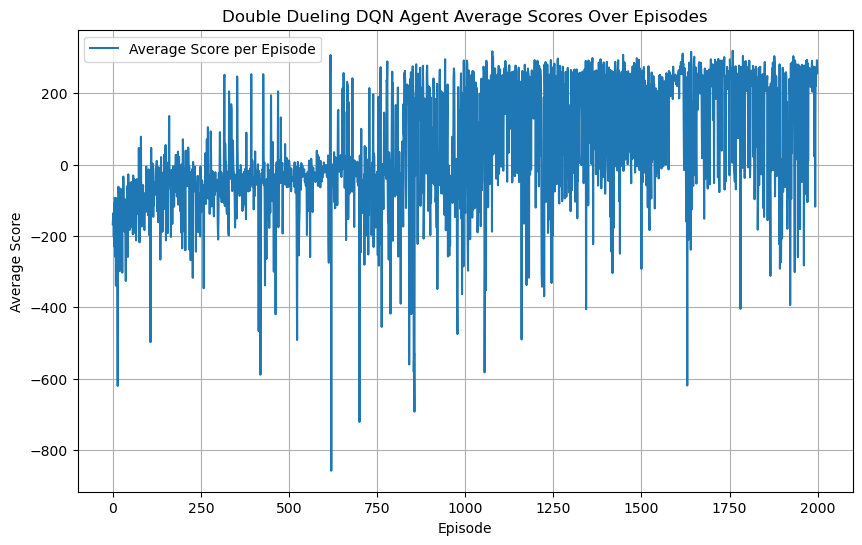

In [14]:
plot_scores(scores, 'Double Dueling DQN Agent Average Scores Over Episodes')